<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разметка-данных" data-toc-modified-id="Разметка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разметка данных</a></span></li><li><span><a href="#Анализ-на-адекватность" data-toc-modified-id="Анализ-на-адекватность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Анализ на адекватность</a></span></li><li><span><a href="#Модели-регрессии" data-toc-modified-id="Модели-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модели регрессии</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Результат-метрики-на-тестовой-выборке." data-toc-modified-id="Результат-метрики-на-тестовой-выборке.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Результат метрики на тестовой выборке.</a></span></li><li><span><a href="#SHAP-анализ" data-toc-modified-id="SHAP-анализ-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>SHAP-анализ</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Согласно проектному заданию, компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* модели машинного обучения на тестовой выборке должно быть не больше 48.

Для выполнения проекта необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



In [1]:
#Обновим критические библиотеки
!pip install -U scipy
!pip install numpy==1.26.4
!pip install -U numba
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install -U seaborn
!pip install -U optuna
!pip install -U shap 
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import shap

import optuna

import lightgbm as lgb
import time

from statsmodels.tsa.seasonal import STL
from statsmodels. tsa.stattools import adfuller


In [3]:
#Установим общие правила
pd.set_option('display.max_columns', None)
sns.set_theme(rc={"figure.dpi": 96})
pd.set_option('mode.chained_assignment', None)

In [4]:
#Установим глобальные переменные
RANDOM_STATE = 42
TEST_SIZE = 0.1
ALPHA = 0.01

In [5]:
#Установим формулу для форматирования графиков
def formatter(x, pos):
    return round(x,0)

## Подготовка

Произведём загрузку и первичный анализ предоставленных данных.

In [6]:
try:
    data_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data_taxi.sort_index(inplace=True)
data_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
print('Дубликатов в данных:',data_taxi.duplicated().sum())

data_taxi.info()

Дубликатов в данных: 26415
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Названия столбцов не нуждаются в исправлении, данные, в целом, соответствуют описанию.  
Данные предоставленые за шестимесячный период, временной ряд предоставленных данных имеет шаг в 10 минут.  
Задача предсказания - почасовая, поэтому проведём ресемплирование данных, и построим графики скользящего среднего и среднеквадратичного отклонения.

## Анализ

In [8]:
data_hour = data_taxi.resample('1H').sum()

In [9]:
data_hour['rolling_mean'] = data_hour.shift().rolling(24).mean() 
data_hour['std'] = data_hour['num_orders'].shift().rolling(24).std()
display(data_hour.head(30))
data_hour.info()

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN
2018-03-01 06:00:00,12,NaN,NaN
2018-03-01 07:00:00,15,NaN,NaN
2018-03-01 08:00:00,34,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   std           4392 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 138.0 KB


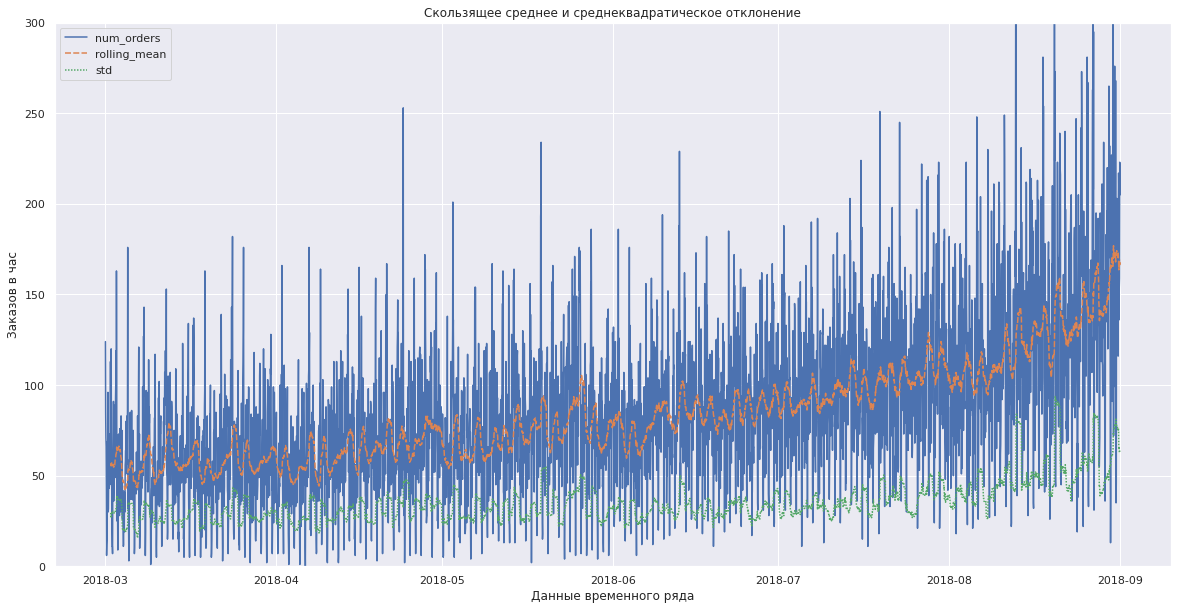

In [10]:
fig, ax = plt.subplots(figsize =(20, 10))
sns.lineplot(data = data_hour, ax = ax);
ax.set_xlabel('Данные временного ряда')
ax.set_ylabel('Заказов в час')
ax.set_title('Скользящее среднее и среднеквадратическое отклонение')
ax.set_ylim(0,300);

Среднее рассматриваемого временного ряда плавно увеличивается, среднеквадратичное отклонение также имеет тенденцию к увеличению.  
Допустимо предположить что временной ряд не является стационарным.

Дополнительно, оценим стационарность ряда, при помощи расширенного теста Дики-Фуллера , в котором используются следующие нулевая и альтернативная гипотезы:

H 0 : Приведённый временной ряд является нестационарным.

H A : Временной ряд является стационарным.

Если p-значение из теста меньше некоторого уровня значимости (например, α = 0,05), то мы можем отвергнуть нулевую гипотезу и сделать вывод, что временной ряд является стационарным.

In [11]:
unit_root = adfuller(data_hour['num_orders'])
display (unit_root)
if unit_root[1] < ALPHA:
    print(f"p-value:{unit_root[1]:3f}")
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print(f"p-value:{unit_root[1]:3f}")
    print('Нет оснований отвергнуть нулевую гипотезу в пользу альтернативной')

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

p-value:0.028940
Нет оснований отвергнуть нулевую гипотезу в пользу альтернативной


Ряд является не является стационарным, однако p-значение близко к порогу значимости.  
Дополнительно рассмотрим приращения первого порядка.

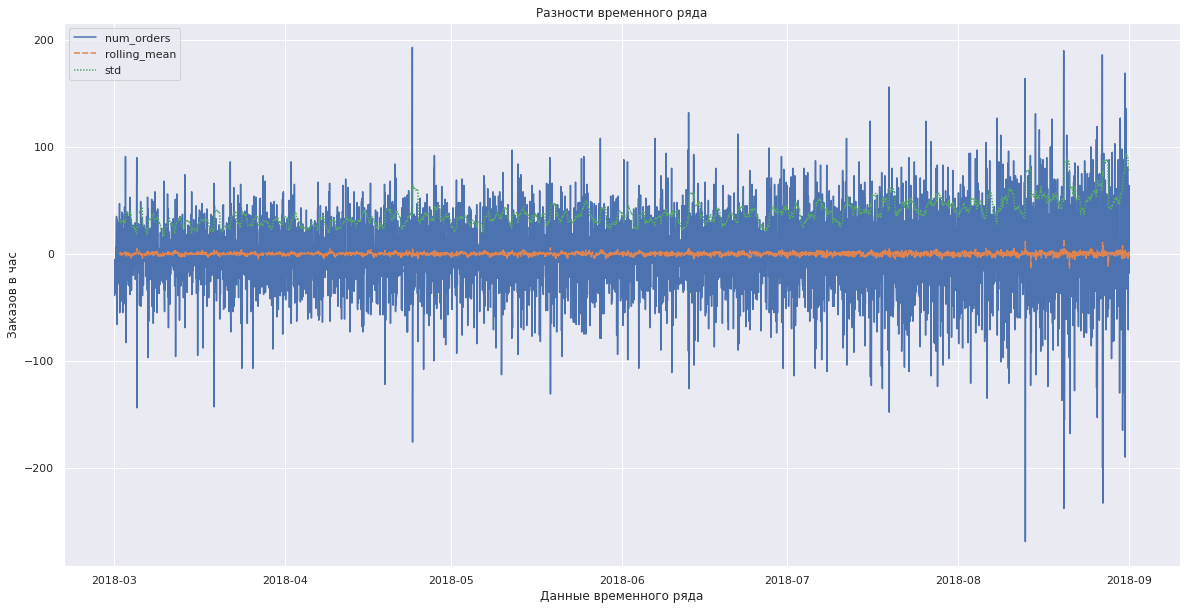

(-15.751195207237794,
 1.2227428665322942e-28,
 31,
 4359,
 {'1%': -3.4318510679201006,
  '5%': -2.8622032882383506,
  '10%': -2.5671230728180445},
 41495.79394166225)

p-value:0.000000
Отвергаем нулевую гипотезу в пользу альтернативной


In [12]:
data_shift = pd.DataFrame(data_hour['num_orders'] - data_hour['num_orders'].shift())
data_shift['rolling_mean'] = data_shift.shift().rolling(24).mean() 
data_shift['std'] = data_shift['num_orders'].shift().rolling(24).std()

fig, ax = plt.subplots(figsize =(20, 10))
sns.lineplot(data = data_shift, ax = ax);
ax.set_xlabel('Данные временного ряда')
ax.set_ylabel('Заказов в час')
ax.set_title('Разности временного ряда');
plt.show();

data_shift = data_shift.dropna()
unit_root = adfuller(data_shift['num_orders'])
display (unit_root)
if unit_root[1] < ALPHA:
    print(f"p-value:{unit_root[1]:3f}")
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print(f"p-value:{unit_root[1]:3f}")
    print('Нет оснований отвергнуть нулевую гипотезу в пользу альтернативной')

Приращения временного ряда - являются стационарными,как по результатам теста, так и по результатам визуального анализа, что может объяснить близкие значения теста Дика-Фуллера на основном временном ряду.

Рассмотрим сезонность спроса на такси, и общую тенденцию заказов.  
Для простоты отображения - рассмотрим заказы в день, длину сезонных колебаний установим в 31 день.  
Анализ сезонности произведём при помощие LOESS алгоритма.

In [13]:
data_day = data_taxi.resample('1D').sum()
data_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


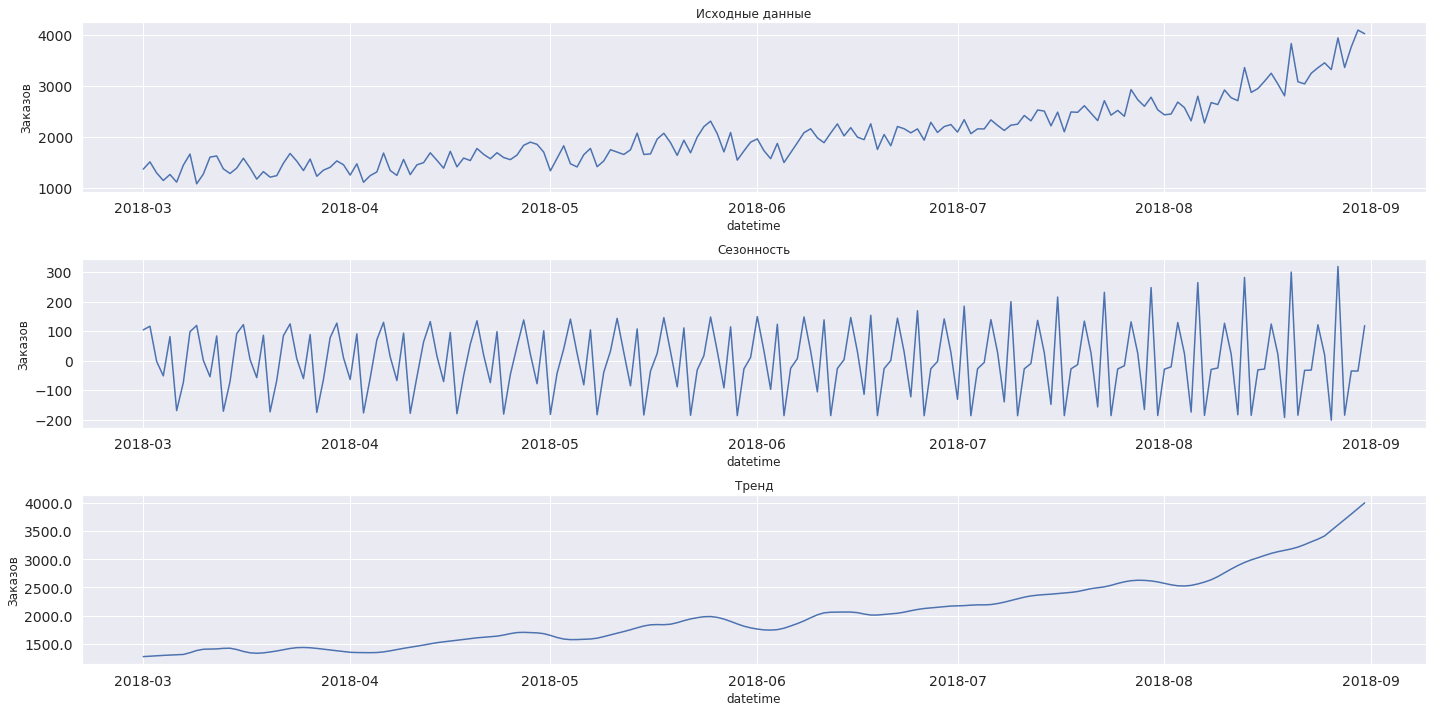

In [14]:
stl = STL(data_day['num_orders'], seasonal=31)
res = stl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

plt.sca(ax1)
sns.lineplot(data = res.observed);
ax1.tick_params(labelsize=14)
ax1.set_ylabel('Заказов')
ax1.set_title('Исходные данные')

plt.sca(ax2)
sns.lineplot(data = res.seasonal);
ax2.tick_params(labelsize=14)
ax2.set_ylabel('Заказов')
ax2.set_title('Сезонность')

plt.sca(ax3)
sns.lineplot(data = res.trend);
ax3.tick_params(labelsize=14)
ax3.set_ylabel('Заказов')
ax3.set_title('Тренд')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
fig.set_size_inches(20, 10)
fig.tight_layout()
plt.show(ax3)

По результату исследования можно выявить общий тренд на повешение количества заказов к концу наблюдаемого периода и периодичость колебаний внутри отдельно взятого месяца.  
Данные, в целом, поддаются дальнейшему прогнозированию.  

Дополнительно рассмотрим отрезок в три дня в начале посследнего приведенного месяца.  
Для них произведём аналогичный анализ сезонности.

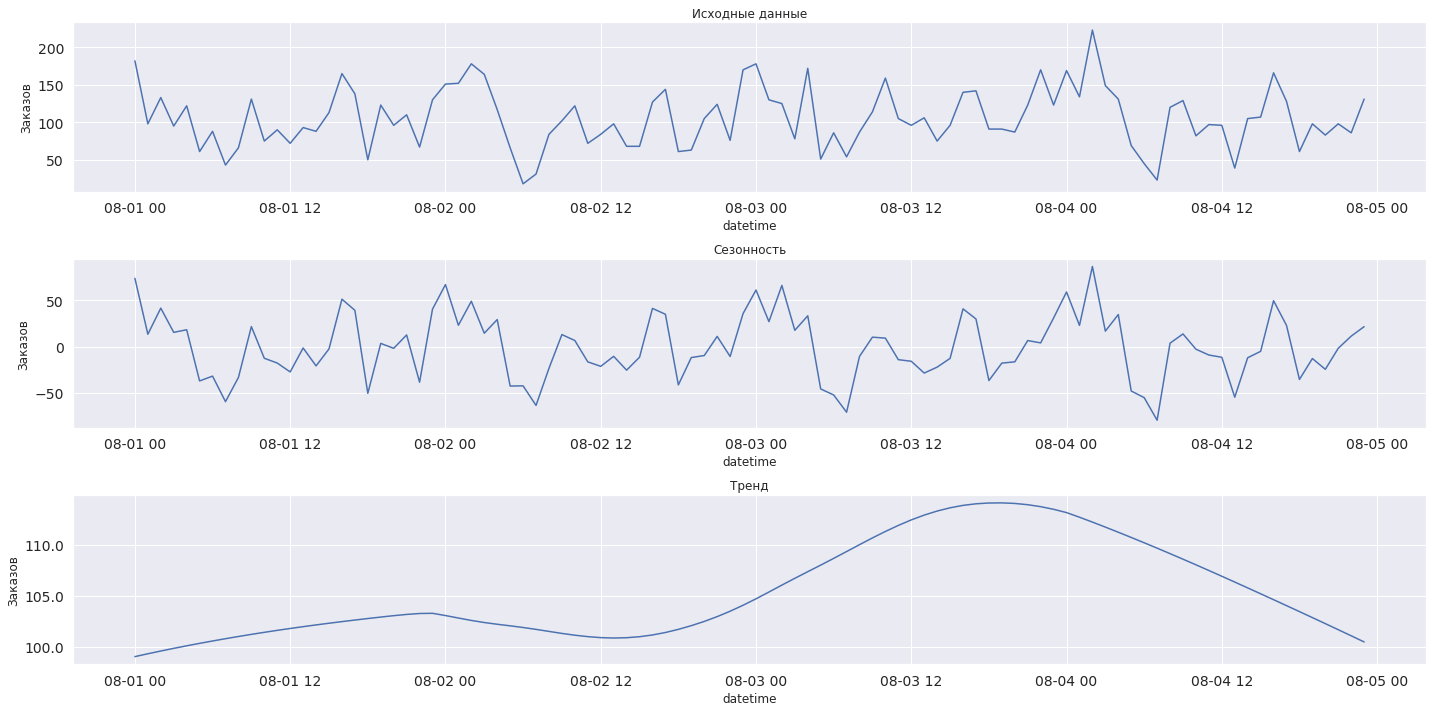

In [15]:
stl = STL(data_hour.loc['2018-08-01':'2018-08-04', 'num_orders'], seasonal=7)
res = stl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

plt.sca(ax1)
sns.lineplot(data = res.observed);
ax1.tick_params(labelsize=14)
ax1.set_ylabel('Заказов')
ax1.set_title('Исходные данные')

plt.sca(ax2)
sns.lineplot(data = res.seasonal);
ax2.tick_params(labelsize=14)
ax2.set_ylabel('Заказов')
ax2.set_title('Сезонность')

plt.sca(ax3)
sns.lineplot(data = res.trend);
ax3.tick_params(labelsize=14)
ax3.set_ylabel('Заказов')
ax3.set_title('Тренд')
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
fig.set_size_inches(20, 10)
fig.tight_layout()
plt.show(ax3)

В приведенных графиках можно наблюдать колебания числа заказов с локальными пиками с полуночи до 6 утра, и резким снижением заказов (до троекратного) около 8 утра.  
Можно предположить, что колебания зависят от прибытия самолётов в аэропорт, либо с работой общественного транспорта.

## Обучение

### Разметка данных

Вынесем календарные данные из индекса и используем для входных признаков.  
Описательные данные (скользящее среднее, среднеквадратическое отклонение - исключим из датасета, для предотварщения утечки данных.  
Данные временного лага не вносились, в связи с достижением необходимых метрик на календарных данных.

In [16]:
#data_hour = data_hour.drop(['rolling_mean', 'std'], axis = 1)
#data_hour['month'] = data_hour.index.month
data_hour['day'] = data_hour.index.day
data_hour['dayofweek'] = data_hour.index.dayofweek
data_hour['hour'] = data_hour.index.hour
data_hour.head()

,num_orders,rolling_mean,std,day,dayofweek,hour
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,3,0
2018-03-01 01:00:00,85,NaN,NaN,1,3,1
2018-03-01 02:00:00,71,NaN,NaN,1,3,2
2018-03-01 03:00:00,66,NaN,NaN,1,3,3
2018-03-01 04:00:00,43,NaN,NaN,1,3,4


Разметим данные для обучения, из тренировочной выборки исключим пропуски.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data_hour.drop(['num_orders'], axis = 1),
    data_hour['num_orders'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    shuffle = False
    )
print('Вновь выявленных дубликатов в данных:',X_train.duplicated().sum())
print('Вновь выявленных пропусков в данных:',X_train['rolling_mean'].isna().sum())
print('Значений в датасете до удаления дубликатов и пропусков:',len(X_train))
y_train = y_train.drop(index = X_train.loc[X_train.duplicated()==True].index)
X_train = X_train.drop_duplicates()
y_train = y_train.drop(index = X_train.loc[X_train['rolling_mean'].isna()==True].index)
X_train = X_train.dropna()
print('Значений в датасете после удаления дубликатов и пропусков:',len(X_train))


Вновь выявленных дубликатов в данных: 0
Вновь выявленных пропусков в данных: 24
Значений в датасете до удаления дубликатов и пропусков: 3974
Значений в датасете после удаления дубликатов и пропусков: 3950


### Анализ на адекватность

Произведём анализ на адекватность - для получения базового значения метрики.

In [18]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)


print(
    'Метрика анализа на адекватность: ',
    root_mean_squared_error(
        y_test, 
        dummy_regr.predict(X_test)
    )
)

Метрика анализа на адекватность:  84.6499381993622


### Модели регрессии

Подбор параметров моделей будет выполняться при помощи библиотеки Optuna.  
Для побора модели модели создаётся инстанс optuna.study, который оптимизирует результат функции в нужную сторону (минимизирует в нашем случае).  
Функция модели включает в себя: параметры для подбора и оптимизации, модель машинного обучения, кросс-валидацию предсказаний и расчёт метрики.  
Вывод функции - значение метрики, которое и минимизируется средствами библиотеки.

In [19]:
#задаём функцию для последующей оптимизации модели LGBMRegressor
def objective(trial):
    #задаём параметры функции через метод suggest - оптуна перебирает предложенные ей параметры
    classifier_name = trial.suggest_categorical("classifier", ["LGB", "Regtree"])
    if classifier_name == "LGB":
    #в завимимости от выбранной модели передаём прочие параметры
        lgb_num_leaves = trial.suggest_int("num_leaves", 25, 45, log=True)
        lgb_max_depth = trial.suggest_int("max_depth", -1, 25, log=False)
        classifier_obj = lgb.LGBMRegressor(
            max_depth = lgb_max_depth,
            num_leaves =  lgb_num_leaves,
            random_state =  RANDOM_STATE
        )
        
    else:
        tree_min_samples_split = trial.suggest_int("min_samples_split", 2, 10, log=True)
        tree_min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10, log=True)
        classifier_obj = DecisionTreeRegressor(
            min_samples_split = tree_min_samples_split,
            min_samples_leaf = tree_min_samples_leaf,
            random_state=RANDOM_STATE
        )
    
    #Обучаем модель
    start = time.time()
    ml_opt = classifier_obj.fit(X_train, y_train)
    ml_time = time.time() - start
    #Задаём дополнительный пользовательский параметр для сохранения модели - в дальнейшем его вызывает функция коллбэка 
    trial.set_user_attr(key="best_model", value=ml_opt)
    trial.set_user_attr(key="best_model_time", value=ml_time)
    #Делаем предсказания, считаем метрику 
    cross_lgb = cross_val_score(classifier_obj, X_train, y_train, cv=TimeSeriesSplit(), scoring='neg_root_mean_squared_error') 
    RMSE = cross_lgb.mean()*-1

    #Возвращаем метрику которую будет оптимизировать оптуна
    return RMSE

In [20]:
#функция коллбэка - чтобы можно было работать напрямую с лучшей модель
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])
        study.set_user_attr(key="best_model_time", value=trial.user_attrs["best_model_time"])

In [21]:
# зададим параметры study, лучшая модель сохраняется как результат функции коллбэка
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler = sampler)
study.optimize(objective, n_trials=35, callbacks=[callback], n_jobs =-1)
best_model=study.user_attrs["best_model"]
best_model_time=study.user_attrs["best_model_time"]
print(study.best_trial)
print()
print('Модель с лучшими гиперапараметрами:',best_model)
print('Время обучения лучшей модели:',best_model_time)

[I 2024-07-14 18:58:06,420] A new study created in memory with name: no-name-a0be261f-a429-4fde-ac63-3c5197da8dcf
[I 2024-07-14 18:58:07,512] Trial 5 finished with value: 32.70055445812581 and parameters: {'classifier': 'Regtree', 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 3 with value: 28.341685402757708.
[I 2024-07-14 18:58:07,516] Trial 3 finished with value: 28.341685402757708 and parameters: {'classifier': 'Regtree', 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 3 with value: 28.341685402757708.
[I 2024-07-14 18:58:07,521] Trial 6 finished with value: 32.05798965570921 and parameters: {'classifier': 'Regtree', 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 3 with value: 28.341685402757708.
[I 2024-07-14 18:58:07,704] Trial 7 finished with value: 32.47746365895834 and parameters: {'classifier': 'Regtree', 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 3 with value: 28.341685402757708.
[I 2024-07-14 18:58:08,217] Trial

FrozenTrial(number=18, state=TrialState.COMPLETE, values=[25.768669758192722], datetime_start=datetime.datetime(2024, 7, 14, 18, 58, 58, 408961), datetime_complete=datetime.datetime(2024, 7, 14, 18, 59, 50, 609082), params={'classifier': 'LGB', 'num_leaves': 28, 'max_depth': 6}, user_attrs={'best_model': LGBMRegressor(max_depth=6, num_leaves=28, random_state=42), 'best_model_time': 9.797225952148438}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('LGB', 'Regtree')), 'num_leaves': IntDistribution(high=45, log=True, low=25, step=1), 'max_depth': IntDistribution(high=25, log=False, low=-1, step=1)}, trial_id=18, value=None)

Модель с лучшими гиперапараметрами: LGBMRegressor(max_depth=6, num_leaves=28, random_state=42)
Время обучения лучшей модели: 9.797225952148438


Произведём тестирование и анализ модели.

## Тестирование

### Результат метрики на тестовой выборке.

In [22]:
y_pred = best_model.predict(X_test)

print('Метрика модели на тестовой выборке:', root_mean_squared_error(y_test, y_pred))

Метрика модели на тестовой выборке: 45.99277595410656


На тестовой выборке RMSE лучшей модели достигает 45 RMSE, что ниже установленного таргета в 48.  
Произведём SHAP-анализ модели.


### SHAP-анализ

In [23]:
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_test, check_additivity=False)

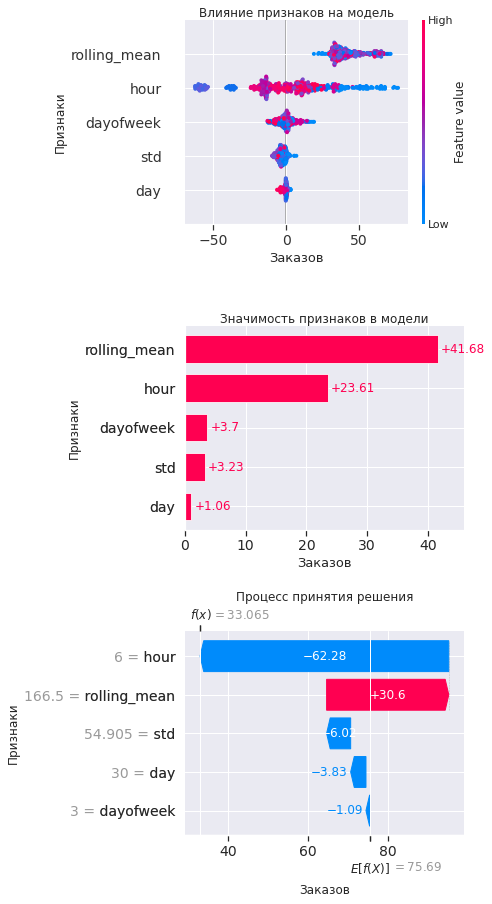

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

plt.sca(ax1)
shap.plots.beeswarm(shap_values, show=False)
plt.subplots_adjust(hspace=0.5)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Заказов', va='top')
ax1.set_title('Влияние признаков на модель', va='top')
ax1.set_ylabel('Признаки')

plt.sca(ax2)
shap.plots.bar(shap_values, show=False)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Заказов', va='top')
ax2.set_title('Значимость признаков в модели', va='top')
ax2.set_ylabel('Признаки')

plt.sca(ax3)
shap.plots.waterfall(shap_values[400], show=False);
ax3.tick_params(labelsize=14)
ax3.set_xlabel('Заказов', va='top')
ax3.set_title('Процесс принятия решения', va='baseline')
ax3.set_ylabel('Признаки')
ax3.xaxis.labelpad = 25
fig.set_size_inches(5, 15)

plt.show(ax3)

Учитывая небольшое количество признаков, тренд и сезонность - предсказуемо самыми влиятельными признаками стали час и окно среднего, кратно превышая влияние прочих.  

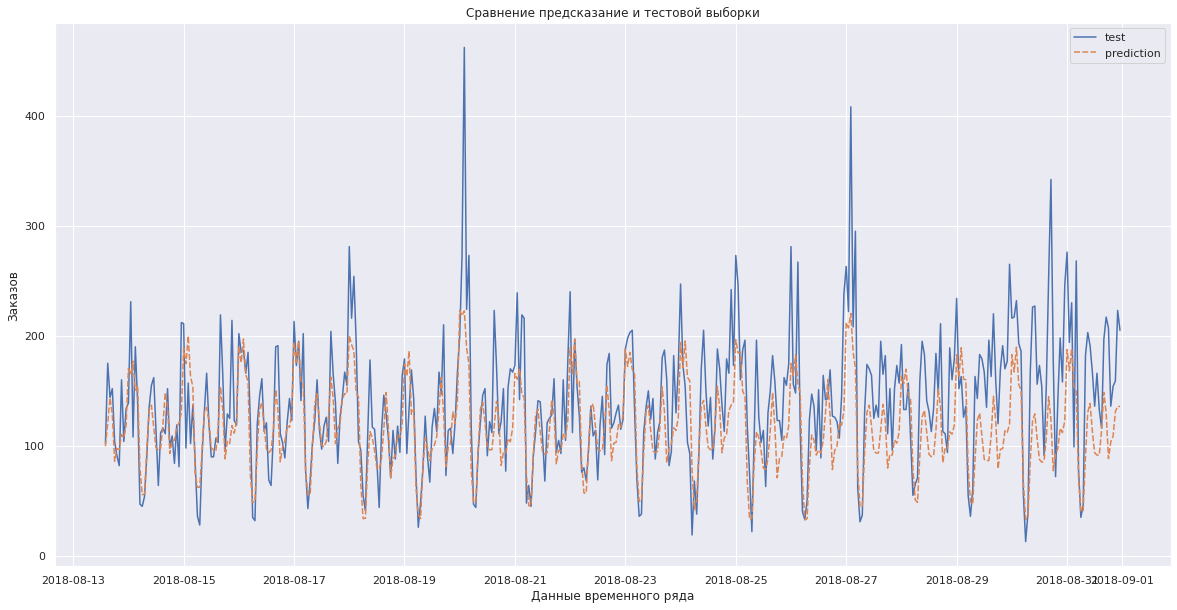

In [25]:
to_plot = pd.DataFrame(y_test)
to_plot['2'] = list(y_pred)
to_plot.columns = ['test','prediction']

fig, ax = plt.subplots(figsize =(20, 10))
sns.lineplot(data = to_plot, ax = ax);
ax.set_xlabel('Данные временного ряда')
ax.set_ylabel('Заказов')
ax.set_title('Cравнение предсказание и тестовой выборки');
plt.show();

Модель в целом верно предсказывает почасовые колебания, но допускает ошибки в локальных пиках заказов.

## Вывод

1) Предоставленные данные не содержат аномалий и пропусков. Проведённый анализ показывает сохраняющийся в течении полугода тренд на увеличение заказов такси, а также периодические колебания до 200 заказов в течении одного месяца.
 

2) По результатам моделирования, лучшая модель - Дерево регрессии с использованием градиентного бустинга (LGBMRegressor). Метрика RMSE достигает 45, при таргете метрики "менее 48".
